In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
from rouge_score import rouge_scorer

import numpy as np

import spacy
nlp = spacy.load("en_core_web_sm")

import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
summary_prefs_ds = load_dataset('amang1802/summary_train')['test']

In [3]:
summary_prefs_ds

Dataset({
    features: ['info', 'summaries', 'choice', 'worker', 'batch', 'split', 'extra', 'query', 'tokens'],
    num_rows: 256
})

In [4]:
def df_from_id(i):
    text = summary_prefs_ds[i]['info']['post']
    choice = summary_prefs_ds[i]['choice']
    chosen = summary_prefs_ds[i]['summaries'][choice]['text']
    rejected = summary_prefs_ds[i]['summaries'][1-choice]['text']
    return pd.DataFrame({"text": [text], "chosen": [chosen], "rejected": [rejected]})

In [5]:
row = df_from_id(140)
row

,text,chosen,rejected
0,I've been on and off with this girl for the past 8 months. She lived with her ex boyfriend but insisted that the were broken up and she didn't want to be with him. He moved away from her 3 months ago and we've been casually seeing each other and having sex. \n\nThis weekend I went on a vacation with her and friends and found out that the ex had her listed as in a relationship on Facebook. When I found this out I messaged the ex and told him of all the times we had sex. I took screen shots of our conversation and told her to never talk to me again. She's since blocked me on Facebook and won't reply to my texts even though she agreed to talk to me about it. \n\nShe was a major part of my support system and I haven't been able to sleep well for 3 days. Does anyone have any advise how to break free from this depression?,"found out she was cheating on me messaged ex with proof that we've been seeing each other, now I'm depressed and need advise.",I'm super depressed and can't get a break from the relationship.


In [6]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [7]:
scorer.score(row.iloc[0]['text'], row.iloc[0]['chosen'])

{'rouge1': Score(precision=0.8, recall=0.11560693641618497, fmeasure=0.20202020202020204),
 'rougeL': Score(precision=0.48, recall=0.06936416184971098, fmeasure=0.12121212121212122)}

In [8]:
scorer.score(row.iloc[0]['text'], row.iloc[0]['rejected'])

{'rouge1': Score(precision=0.6923076923076923, recall=0.05202312138728324, fmeasure=0.0967741935483871),
 'rougeL': Score(precision=0.46153846153846156, recall=0.03468208092485549, fmeasure=0.06451612903225806)}

### What's the expected summary length?

Let's analyze the distribution of lengths of the chosen summaries

In [9]:
def word_count(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.is_alpha)

In [10]:
def chosen_summary_metrics(row):
    choice = row['choice']
    chosen = row['summaries'][choice]['text']
    return {"word_count_chosen": word_count(chosen), "chosen_summary": chosen}

In [11]:
chosen_metrics_ds = summary_prefs_ds.map(chosen_summary_metrics)

In [12]:
summary_lengths = np.array(chosen_metrics_ds['word_count_chosen'])
print("Mean: ", summary_lengths.mean())
print("Std Dev: ", summary_lengths.std())

Mean:  26.61328125
Std Dev:  10.508314201545291


(array([14., 18., 45., 35., 30., 48., 24.,  7., 11.,  6.,  3.,  7.,  2.,
         1.,  1.,  0.,  3.,  0.,  0.,  1.]),
 array([10.  , 13.35, 16.7 , 20.05, 23.4 , 26.75, 30.1 , 33.45, 36.8 ,
        40.15, 43.5 , 46.85, 50.2 , 53.55, 56.9 , 60.25, 63.6 , 66.95,
        70.3 , 73.65, 77.  ]),
 <BarContainer object of 20 artists>)

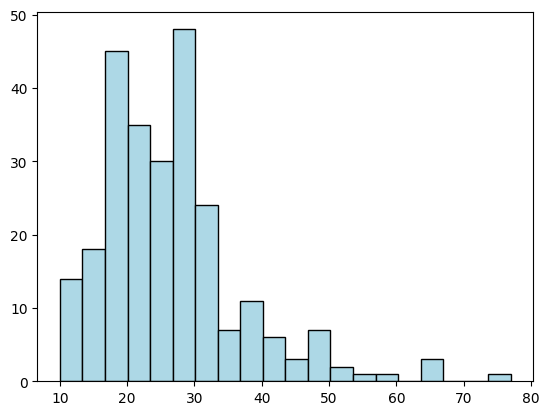

In [13]:
plt.hist(chosen_metrics_ds['word_count_chosen'], color='lightblue', ec='black', bins=20)

In [14]:
plt.close()

### Model generated summary length distribution

In [15]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
llm = LLM(model=model_id, max_model_len=4096)

INFO 12-06 16:00:24 config.py:350] This model supports multiple tasks: {'embedding', 'generate'}. Defaulting to 'generate'.
INFO 12-06 16:00:24 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llama/Lla

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-06 16:00:26 model_runner.py:1077] Loading model weights took 2.3185 GB
INFO 12-06 16:00:27 worker.py:232] Memory profiling results: total_gpu_memory=23.69GiB initial_memory_usage=3.26GiB peak_torch_memory=3.51GiB memory_usage_post_profile=3.27GiB non_torch_memory=0.94GiB kv_cache_size=16.87GiB gpu_memory_utilization=0.90
INFO 12-06 16:00:27 gpu_executor.py:113] # GPU blocks: 34551, # CPU blocks: 8192
INFO 12-06 16:00:27 gpu_executor.py:117] Maximum concurrency for 4096 tokens per request: 134.96x
INFO 12-06 16:00:28 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-06 16:00:28 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO

In [17]:
def text_to_messages(info, target_words):
    return [
        {"role": "system", "content": f"Summarize the text using exactly {target_words} words:"},
        {"role": "user", "content": info['post']}
    ]
    
def summarize_batch(batch, llm, tokenizer, target_words):
    prompts = [tokenizer.apply_chat_template(text_to_messages(text, target_words), add_generation_prompt=True, tokenize=False)
               for text in batch]
    sampling_params = SamplingParams(temperature=0.25, max_tokens=128)
    outputs = llm.generate(prompts, sampling_params)

    return {"llm_summary": [output.outputs[0].text.strip() for output in outputs]}

In [18]:
gen_summaries = chosen_metrics_ds.map(lambda batch: summarize_batch(batch, llm, tokenizer, 31),
                                     input_columns=['info'],
                                     batched=True,
                                     batch_size=256)

Parameter 'function'=<function <lambda> at 0x7f80dc760680> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]


Processed prompts: 100%|█████████████| 256/256 [00:04<00:00, 56.96it/s, est. speed input: 19436.69 toks/s, output: 3249.75 toks/s]


In [19]:
gen_summaries['llm_summary'][:5]

["Here's a summary of the text in exactly 31 words:\n\nYou're concerned about your friend's behavior, concerned about his skewed view of sex, and want to confront him about his recent hookups, but need a safe and effective way to approach the situation.",
 "The writer is unsure how to interpret the woman's openness, which may indicate a desire for a romantic or intimate connection, but also raises concerns about her intentions and boundaries.",
 "It sounds like you're feeling conflicted about attending a family gathering and a party. Here's a 31-word summary:\n\nYou're torn between feeling guilty for not attending family events and enjoying a party with friends. Consider having an open conversation with your mom to clear up the misunderstanding and find a solution that works for everyone.",
 'A person was repeatedly calling a landline phone number, breathing for 2 seconds before hanging up, and the caller claimed to be a patient from a special needs institute, causing frustration and a

In [20]:
def rouge_score(chosen, generated):
    score = scorer.score(chosen, generated)
    return score['rouge1'].fmeasure, score['rougeL'].fmeasure

In [21]:
def llm_summary_metrics(chosen, generated):
    rouge1, rougeL = rouge_score(chosen, generated)
    return {"word_count_llm_summary": word_count(generated), 'rouge1': rouge1, 'rougeL': rougeL}

In [22]:
llm_metrics_ds = gen_summaries.map(llm_summary_metrics, input_columns=['chosen_summary', 'llm_summary'])

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

In [23]:
summary_lengths = np.array(llm_metrics_ds['word_count_llm_summary'])
print("Mean: ", summary_lengths.mean())
print("Std Dev: ", summary_lengths.std())

Mean:  44.59375
Std Dev:  27.538733375692864


(array([ 3.,  3., 25., 39., 43., 32., 26., 19., 11.,  5.,  1.,  1.,  1.,
         0.,  1.,  7., 15., 18.,  4.,  2.]),
 array([  5. ,  10.5,  16. ,  21.5,  27. ,  32.5,  38. ,  43.5,  49. ,
         54.5,  60. ,  65.5,  71. ,  76.5,  82. ,  87.5,  93. ,  98.5,
        104. , 109.5, 115. ]),
 <BarContainer object of 20 artists>)

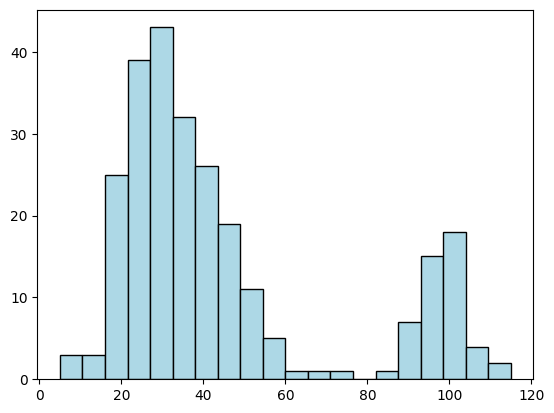

In [24]:
plt.hist(summary_lengths, color='lightblue', ec='black', bins=20)

In [25]:
plt.close()

In [26]:
rouge1_scores = np.array(llm_metrics_ds['rouge1'])
rougeL_scores = np.array(llm_metrics_ds['rougeL'])
print("Rouge1.fmeasure Mean: ", rouge1_scores.mean())
print("RougeL.fmeasure Mean: ", rougeL_scores.mean())

Rouge1.fmeasure Mean:  0.1859368127738743
RougeL.fmeasure Mean:  0.131804314879524


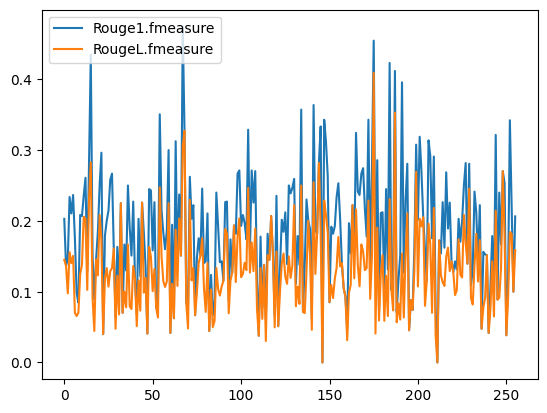

In [27]:
plt.plot(range(llm_metrics_ds.num_rows), llm_metrics_ds['rouge1'], label="Rouge1.fmeasure")
plt.plot(range(llm_metrics_ds.num_rows), llm_metrics_ds['rougeL'], label="RougeL.fmeasure")
plt.legend(loc="upper left")
plt.show()